In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 3
hidden_size = 900
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 1e-3
model_name = "20210810_Prediction-1LSTM-3Mixtures-900Hidden-256Batch-Mask"


cuda:1


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [5]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

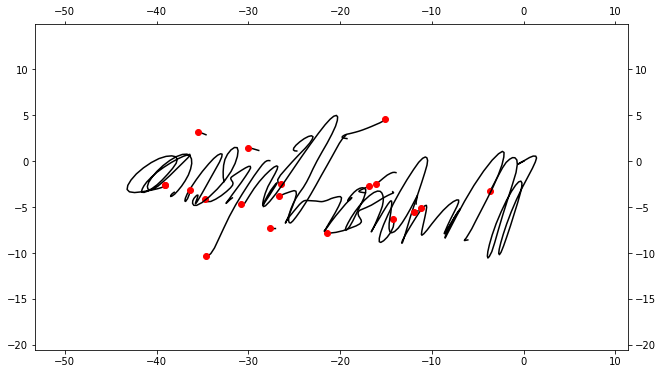

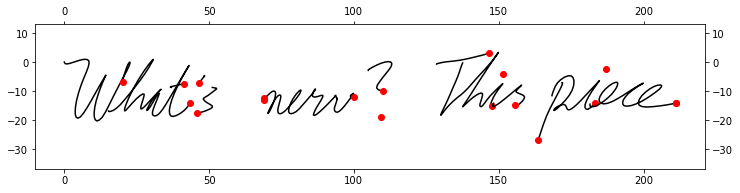

What 's new? This piece


In [8]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]-1))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lengths[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lengths[10000:])


In [10]:
dl = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=2,
    drop_last=True)

k = iter(dl)
for j in range(4):
    print("JJJJJJJJJJJJJJJJJ:", j)
    s, l, m = next(k)
    l0 = l[0]
    l1 = l[1]
    l
    s.shape
    m.shape

    print("Testing the 0th position of every stroke")
    s[:,0,:]

    print("testing the length location of stroke")
    s[0,l0-2:l0+2, :]
    s[1,l1-2:l1+2, :]

    print("testing the length location of mask")
    m[0,l0-2:l0+2]
    m[1,l1-2:l1+2]

JJJJJJJJJJJJJJJJJ: 0


tensor([810, 150], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[ 0.1318, -0.3933,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.1470,  0.0026,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 1


tensor([729, 488], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.5986, -0.3101,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[0.0453, 0.0127, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 2


tensor([469, 807], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[ 0.2255, -0.1211,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.0361,  0.1051,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 3


tensor([746, 620], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.2013, -0.1424,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.4687,  0.0222,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

In [11]:
from einops import rearrange 

class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size # 3
        self.hidden_size = hidden_size # 900
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h0, c0):
        bs = x.shape[0]
        out_1, (hn, cn) = self.lstmLayer(x, (h0, c0))
        out_1 = rearrange(out_1, 'b l h -> (b l) h')
        out_2 = self.linearLayer(out_1)
        out_2 = rearrange(out_2, '(b l) o -> b l o', b = bs)
        return out_2, (hn, cn)

In [12]:
inputs = torch.randn(2, 10, 3)
lengths = torch.tensor([5, 3])
inputs[0, 5:, :] = 0
inputs[1, 3:, :] = 0
inputs
lengths
p = Prediction(3, 4, 7)
p(inputs, torch.zeros(1, 2, 4), torch.zeros(1, 2, 4))[0].shape

tensor([[[-0.8143, -0.9395,  1.5960],
         [ 1.4583,  1.2910, -0.6237],
         [-0.6308, -1.3617, -0.9729],
         [-0.3073,  1.9214, -0.2337],
         [-0.4276,  0.2782, -0.0139],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.6013, -0.0518, -0.3098],
         [-0.2597,  0.9492,  0.4434],
         [ 0.9384, -0.0239,  0.9341],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

tensor([5, 3])

torch.Size([2, 10, 7])

In [13]:
def get_mixture_params_from_output(outputs):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    pis = nn.Softmax(2)(outputs[:,:,:n_mixtures])
    mus = rearrange(outputs[:,:,n_mixtures:3*n_mixtures], 'b l (n d) -> b l n d', d=2)
    
    sigmas = rearrange(torch.exp(outputs[:,:,3*n_mixtures:5*n_mixtures]), 'b l (n d) -> b l n d', d=2)
    phos = rearrange(torch.tanh(outputs[:,:,5*n_mixtures:6*n_mixtures]), 'b l (n d) -> b l n d', d=1)
    
    covs = torch.zeros(outputs.shape[0], outputs.shape[1], n_mixtures, 2, 2, device=device)
    covs[:,:,:,0,0] = sigmas[:,:,:,0]**2
    covs[:,:,:,1,1] = sigmas[:,:,:,1]**2
    covs[:,:,:,0,1] = phos[:,:,:,0] * sigmas[:,:,:,0] * sigmas[:,:,:,1]
    covs[:,:,:,1,0] = covs[:,:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,:,-1]))

def nll(outputs, targets, mask_batch):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    # targets: b, max_len-1, 3
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,:,0:2].unsqueeze(2).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=2)
    # target_coords: b, max_len-1, n_mixtures, 3
    stroke_lift = targets[:,:,-1] # b, max_len-1, 1
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords)
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=2)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    loss_per_point *= mask_batch
    
    return loss_per_point.sum()/outputs.shape[0]

In [14]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        outputs, (h_next, c_next) = model(point_prev.unsqueeze(0).unsqueeze(0), h_prev, c_prev)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0).squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0).squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [15]:
from einops import rearrange

def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    inputs = strokes_batch[:, :-1, :]
    targets = strokes_batch[:, 1:, :]
    return inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, mask_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    loss = nll(outputs, targets, mask_batch)
    loss.backward()
    #### Do Gradient clipping here if need be
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch, mask_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                mask_batch,
                h0, c0)
            h0 = h0.detach()
            c0 = c0.detach()
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                for i in range(3):
                    sample_stroke = sample(model)
                    sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                    sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                    draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [16]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


iteration: 0 of 39000, avg_loss: 43.37, timeSinceStart: 2.91, Epoch: 0


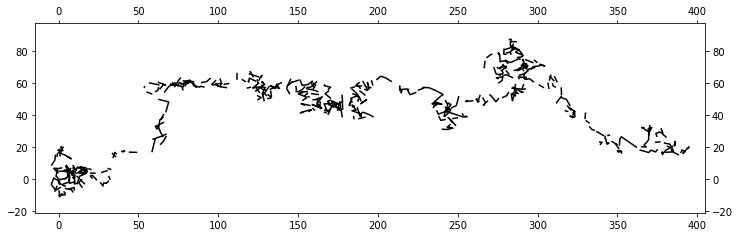

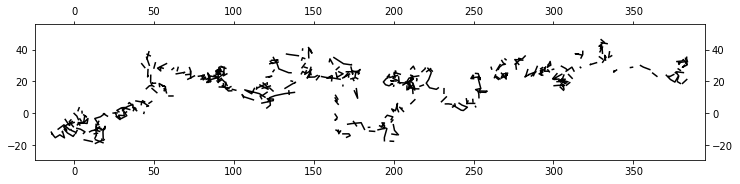

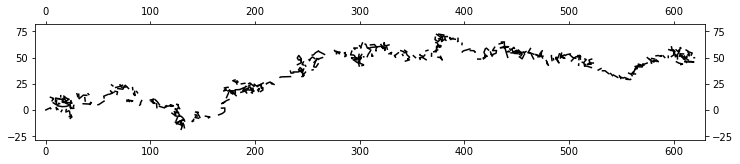

iteration: 50 of 39000, avg_loss: 1371.37, timeSinceStart: 60.04, Epoch: 1
iteration: 100 of 39000, avg_loss: 413.56, timeSinceStart: 112.44, Epoch: 2
iteration: 150 of 39000, avg_loss: -472.53, timeSinceStart: 165.00, Epoch: 3
iteration: 200 of 39000, avg_loss: -981.82, timeSinceStart: 218.02, Epoch: 5
iteration: 250 of 39000, avg_loss: -1185.49, timeSinceStart: 271.05, Epoch: 6


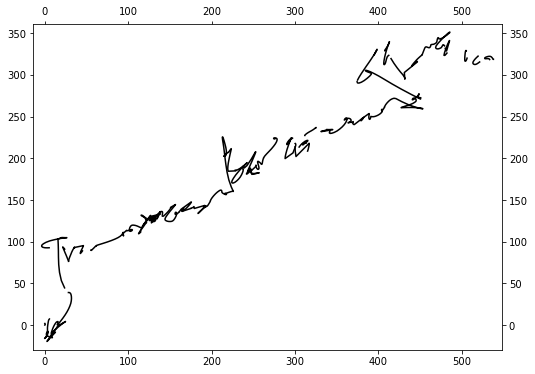

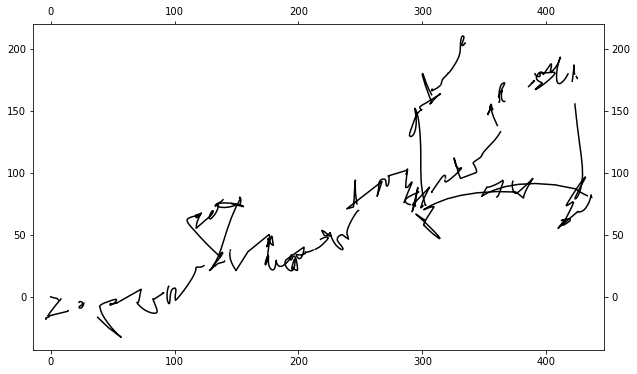

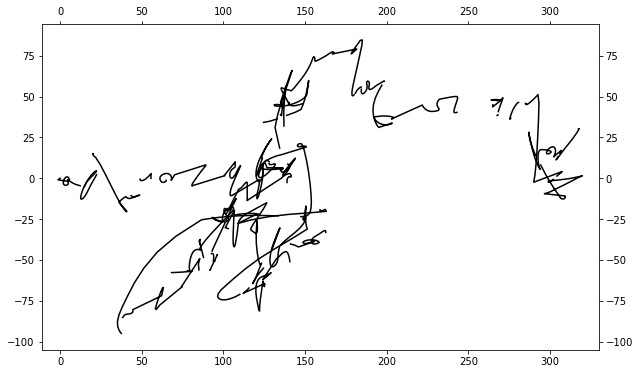

iteration: 300 of 39000, avg_loss: -1359.53, timeSinceStart: 327.76, Epoch: 7
iteration: 350 of 39000, avg_loss: -1400.52, timeSinceStart: 380.65, Epoch: 8
iteration: 400 of 39000, avg_loss: -1419.82, timeSinceStart: 433.69, Epoch: 10
iteration: 450 of 39000, avg_loss: -1493.25, timeSinceStart: 486.54, Epoch: 11
iteration: 500 of 39000, avg_loss: -1513.10, timeSinceStart: 539.35, Epoch: 12


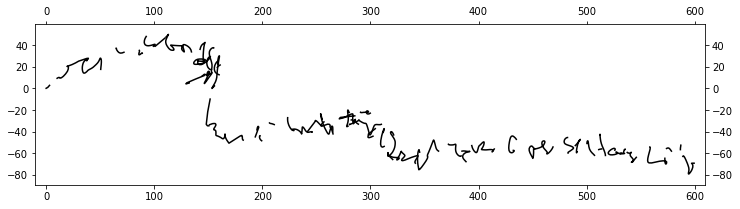

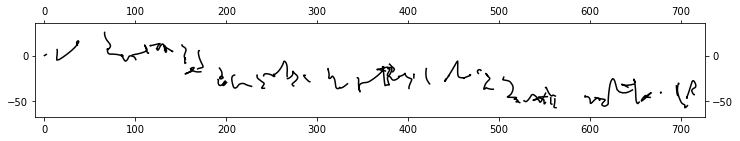

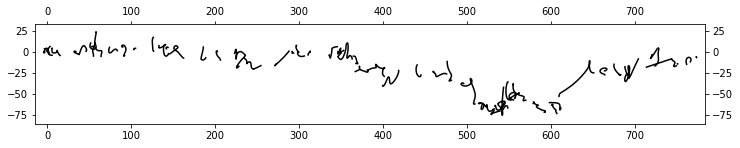

iteration: 550 of 39000, avg_loss: -1537.32, timeSinceStart: 596.16, Epoch: 14
iteration: 600 of 39000, avg_loss: -1556.44, timeSinceStart: 649.03, Epoch: 15
iteration: 650 of 39000, avg_loss: -1573.32, timeSinceStart: 701.92, Epoch: 16
iteration: 700 of 39000, avg_loss: -1590.89, timeSinceStart: 754.77, Epoch: 17
iteration: 750 of 39000, avg_loss: -1611.87, timeSinceStart: 807.59, Epoch: 19


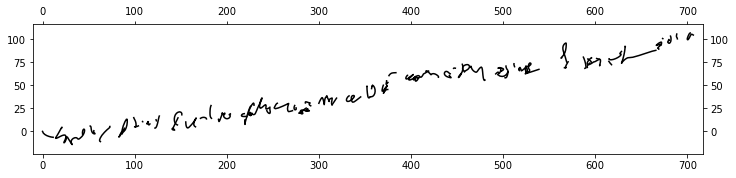

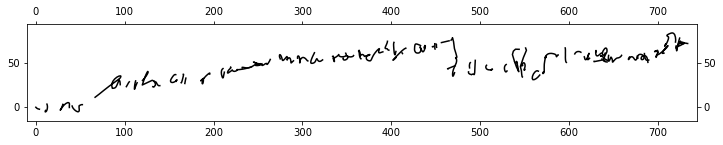

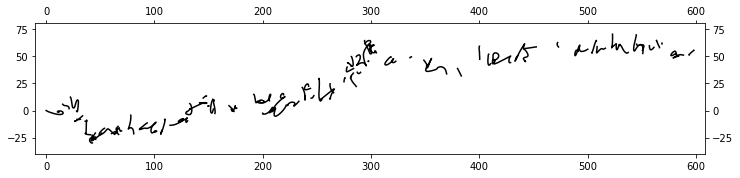

iteration: 800 of 39000, avg_loss: -1632.46, timeSinceStart: 864.34, Epoch: 20
iteration: 850 of 39000, avg_loss: -1640.48, timeSinceStart: 917.19, Epoch: 21
iteration: 900 of 39000, avg_loss: -1658.82, timeSinceStart: 970.09, Epoch: 23
iteration: 950 of 39000, avg_loss: -1662.89, timeSinceStart: 1022.90, Epoch: 24
iteration: 1000 of 39000, avg_loss: -1682.03, timeSinceStart: 1075.81, Epoch: 25


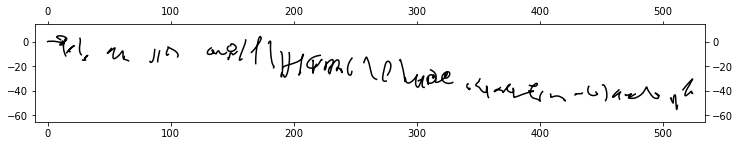

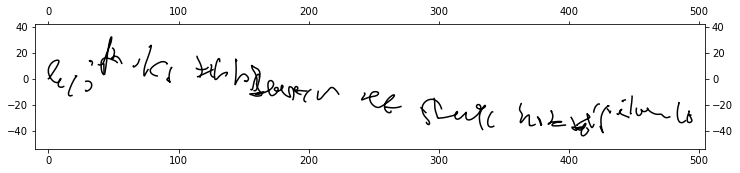

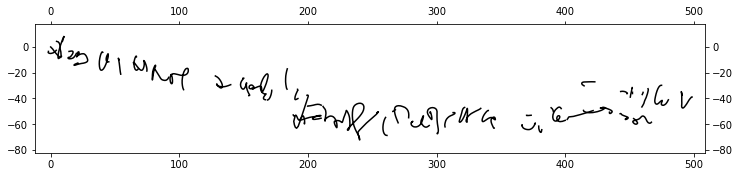

iteration: 1050 of 39000, avg_loss: -1719.15, timeSinceStart: 1132.48, Epoch: 26
iteration: 1100 of 39000, avg_loss: -1731.51, timeSinceStart: 1185.44, Epoch: 28
iteration: 1150 of 39000, avg_loss: -1767.12, timeSinceStart: 1238.44, Epoch: 29
iteration: 1200 of 39000, avg_loss: -1773.45, timeSinceStart: 1291.26, Epoch: 30
iteration: 1250 of 39000, avg_loss: -1788.97, timeSinceStart: 1344.08, Epoch: 32


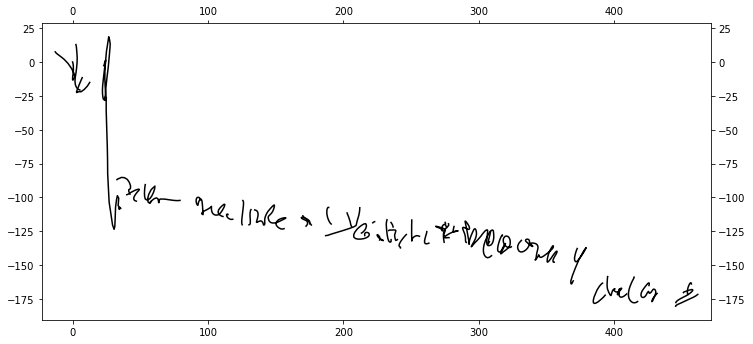

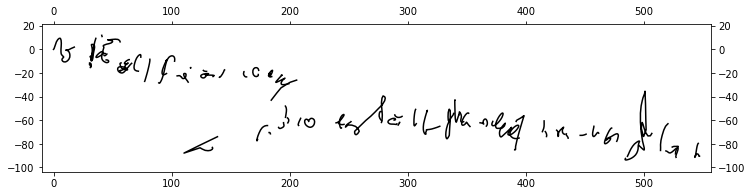

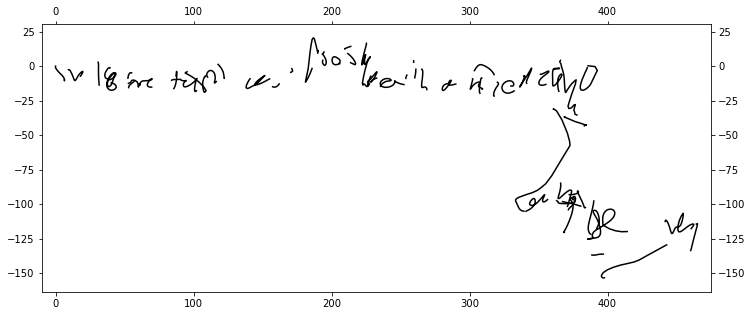

iteration: 1300 of 39000, avg_loss: -1796.17, timeSinceStart: 1401.17, Epoch: 33
iteration: 1350 of 39000, avg_loss: -1823.19, timeSinceStart: 1454.31, Epoch: 34
iteration: 1400 of 39000, avg_loss: -1813.23, timeSinceStart: 1507.41, Epoch: 35
iteration: 1450 of 39000, avg_loss: -1835.38, timeSinceStart: 1560.59, Epoch: 37
iteration: 1500 of 39000, avg_loss: -1820.71, timeSinceStart: 1613.69, Epoch: 38


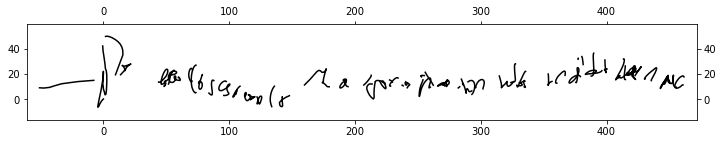

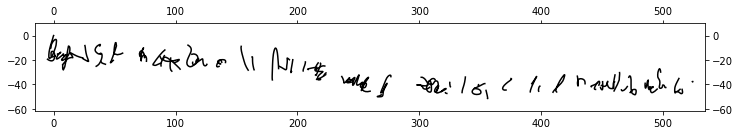

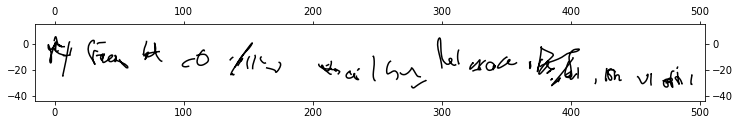

iteration: 1550 of 39000, avg_loss: -1841.79, timeSinceStart: 1670.71, Epoch: 39
iteration: 1600 of 39000, avg_loss: -1850.03, timeSinceStart: 1723.68, Epoch: 41
iteration: 1650 of 39000, avg_loss: -1852.86, timeSinceStart: 1776.71, Epoch: 42
iteration: 1700 of 39000, avg_loss: -1863.38, timeSinceStart: 1829.78, Epoch: 43
iteration: 1750 of 39000, avg_loss: -1867.71, timeSinceStart: 1882.80, Epoch: 44


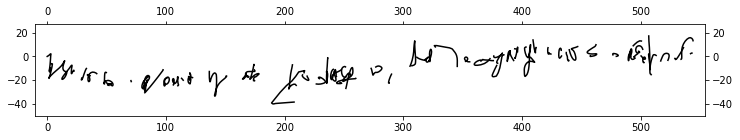

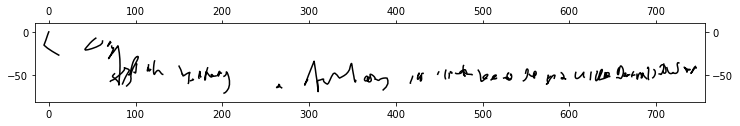

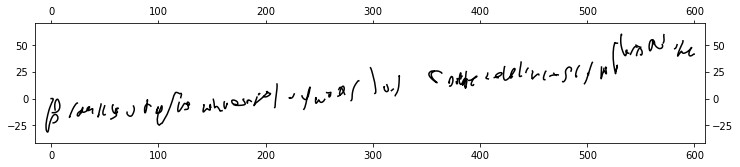

iteration: 1800 of 39000, avg_loss: -1869.08, timeSinceStart: 1939.65, Epoch: 46
iteration: 1850 of 39000, avg_loss: -1873.71, timeSinceStart: 1992.59, Epoch: 47
iteration: 1900 of 39000, avg_loss: -1887.49, timeSinceStart: 2045.70, Epoch: 48
iteration: 1950 of 39000, avg_loss: -1884.25, timeSinceStart: 2098.74, Epoch: 50
iteration: 2000 of 39000, avg_loss: -1904.61, timeSinceStart: 2151.68, Epoch: 51


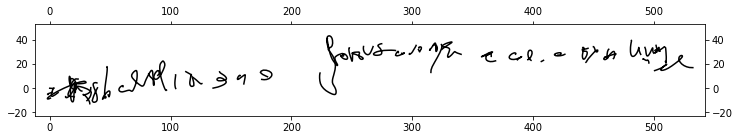

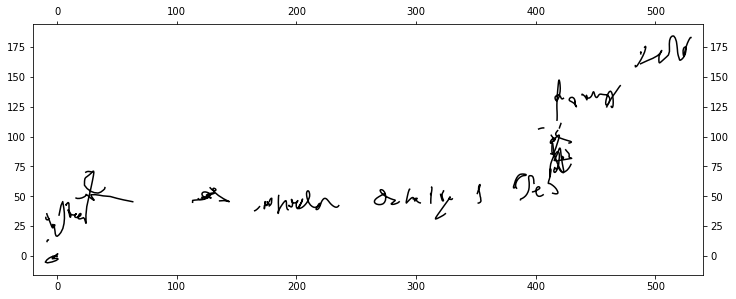

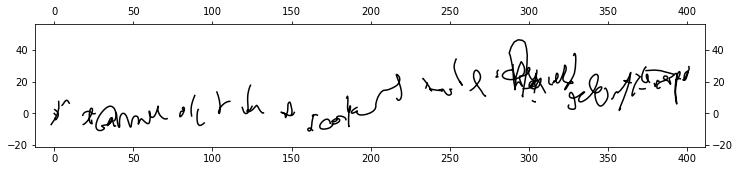

iteration: 2050 of 39000, avg_loss: -1885.45, timeSinceStart: 2208.51, Epoch: 52
iteration: 2100 of 39000, avg_loss: -1904.49, timeSinceStart: 2261.56, Epoch: 53
iteration: 2150 of 39000, avg_loss: -1903.58, timeSinceStart: 2314.68, Epoch: 55
iteration: 2200 of 39000, avg_loss: -1917.67, timeSinceStart: 2367.76, Epoch: 56
iteration: 2250 of 39000, avg_loss: -1913.67, timeSinceStart: 2420.74, Epoch: 57


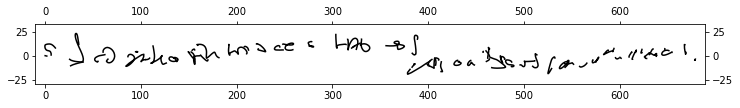

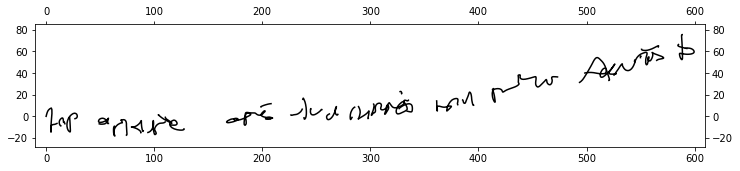

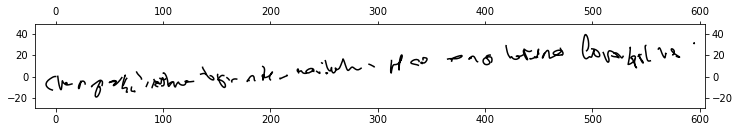

iteration: 2300 of 39000, avg_loss: -1927.48, timeSinceStart: 2477.67, Epoch: 58
iteration: 2350 of 39000, avg_loss: -1932.76, timeSinceStart: 2530.65, Epoch: 60
iteration: 2400 of 39000, avg_loss: -1930.11, timeSinceStart: 2583.73, Epoch: 61


ValueError: Expected parameter loc (Tensor of shape (256, 1199, 3, 2)) of distribution MultivariateNormal(loc: torch.Size([256, 1199, 3, 2]), covariance_matrix: torch.Size([256, 1199, 3, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]],


        ...,


        [[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]]], device='cuda:1', grad_fn=<ExpandBackward>)

In [17]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
